In [ ]:
%install '.package(path: "$cwd/FastaiNotebook_04_callbacks")' FastaiNotebook_04_callbacks

Installing packages:
	.package(path: "/home/marcrasi/fastai_docs/dev_swift/FastaiNotebook_04_callbacks")
		FastaiNotebook_04_callbacks
With SwiftPM flags: []
Working in: /tmp/tmp79vlv47o
Fetching https://github.com/mxcl/Path.swift
Fetching https://github.com/JustHTTP/Just
Completed resolution in 2.54s
Cloning https://github.com/mxcl/Path.swift
Resolving https://github.com/mxcl/Path.swift at 0.16.2
Cloning https://github.com/JustHTTP/Just
Resolving https://github.com/JustHTTP/Just at 0.7.1
Compile Swift Module 'Just' (1 sources)
Compile Swift Module 'Path' (9 sources)
Compile Swift Module 'FastaiNotebook_04_callbacks' (6 sources)
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Linking ./.build/x86_64-unknown-linux/debug/libjupyterInstalledPackages.so
Initializing Swift...
Loading library...
Installation complete!


In [ ]:
import TensorFlow
import FastaiNotebook_04_callbacks
import Path
import TensorFlow

class LayerDelegate<Output> {
    func didProduceActivation(_ activation: Output, in context: Context) {}
}

protocol FALayer: Layer {
    @differentiable
    func forward(_ input: Input, in context: Context) -> Output
    
    var delegate: LayerDelegate<Output> { get set }
}

In [ ]:
// We couldn't get this to work, so we're just manually pasting this "applied" implementation into
// all FALayers for now.
// TODO: Get this to work.

// extension FALayer {
//     @differentiable
//     public func applied(to input: Input, in context: Context) -> Output {
//         let activation = forward(input, in: context)
//         delegate.didProduceActivation(activation, in: context)
//         return activation
//     }
// }

In [ ]:
/// A densely-connected neural network layer.
///
/// `Dense` implements the operation `activation(matmul(input, weight) + bias)`, where `weight` is
/// a weight matrix, `bias` is a bias vector, and `activation` is an element-wise activation
/// function.
@_fixed_layout
public struct FADense<Scalar: TensorFlowFloatingPoint>: FALayer {    
    /// The weight matrix.
    public var weight: Tensor<Scalar>
    /// The bias vector.
    public var bias: Tensor<Scalar>
    public typealias Activation = @differentiable (Tensor<Scalar>) -> Tensor<Scalar>
    /// The element-wise activation function.
    @noDerivative public let activation: Activation
    
    @noDerivative public var delegate: LayerDelegate<Tensor<Scalar>> = LayerDelegate()

    public init(
        weight: Tensor<Scalar>,
        bias: Tensor<Scalar>,
        activation: @escaping Activation
    ) {
        self.weight = weight
        self.bias = bias
        self.activation = activation
    }

    /// Returns the output obtained from applying the layer to the given input.
    ///
    /// - Parameters:
    ///   - input: The input to the layer.
    ///   - context: The contextual information for the layer application, e.g. the current learning
    ///     phase.
    /// - Returns: The output.
    @differentiable
    public func forward(_ input: Tensor<Scalar>, in _: Context) -> Tensor<Scalar> {
        return activation(matmul(input, weight) + bias)
    }
    
    @differentiable
    public func applied(to input: Tensor<Scalar>, in context: Context) -> Tensor<Scalar> {
        let activation = forward(input, in: context)
        delegate.didProduceActivation(activation, in: context)
        return activation
    }
}

In [ ]:
public extension FADense {
    /// Creates a `Dense` layer with the specified input size, output size, and element-wise
    /// activation function. The weight matrix is created with shape `[inputSize, outputSize]` and
    /// is initialized using Glorot uniform initialization with the specified seed. The bias vector
    /// is created with shape `[outputSize]` and is initialized with zeros.
    ///
    /// - Parameters:
    ///   - inputSize: The dimensionality of the input space.
    ///   - outputSize: The dimensionality of the output space.
    ///   - activation: The activation function to use. The default value is `identity(_:)`.
    ///   - seed: The random seed for initialization. The default value is random.
    init(
        inputSize: Int,
        outputSize: Int,
        activation: @escaping Activation = identity,
        seed: (Int64, Int64) = (Int64.random(in: Int64.min..<Int64.max),
                                Int64.random(in: Int64.min..<Int64.max))
    ) {
        self.init(weight: Tensor(glorotUniform: [Int32(inputSize), Int32(outputSize)],
                                 seed: seed),
                  bias: Tensor(zeros: [Int32(outputSize)]),
                  activation: activation)
    }
}

In [ ]:
let data = mnistDataBunch(flat: true)
let (n,m) = (60000,784)
let c = 10
let nHid = 50

In [ ]:
public struct MyModel: FALayer {
    public var layer1: FADense<Float>
    public var layer2: FADense<Float>
    
    @noDerivative public var delegate: LayerDelegate<Tensor<Float>> = LayerDelegate()
    
    public init(nIn: Int, nHid: Int, nOut: Int){
        layer1 = FADense(inputSize: nIn, outputSize: nHid, activation: relu)
        layer2 = FADense(inputSize: nHid, outputSize: nOut)
    }
    
    @differentiable
    public func forward(_ input: Tensor<Float>, in context: Context) -> Tensor<Float> {
        return input.sequenced(in: context, through: layer1, layer2)
    }

    @differentiable
    public func applied(to input: Tensor<Float>, in context: Context) -> Tensor<Float> {
        let activation = forward(input, in: context)
        delegate.didProduceActivation(activation, in: context)
        return activation
    }
}

In [ ]:
var opt = SGD<MyModel, Float>(learningRate: 1e-2)
func modelInit() -> MyModel {return MyModel(nIn: m, nHid: nHid, nOut: c)}

// TODO: When TF-421 is fixed, switch back to the normal `softmaxCrossEntropy`.

@differentiable(vjp: _vjpSoftmaxCrossEntropy)
func softmaxCrossEntropy1<Scalar: TensorFlowFloatingPoint>(
    _ features: Tensor<Scalar>, _ labels: Tensor<Scalar>
) -> Tensor<Scalar> {
    return Raw.softmaxCrossEntropyWithLogits(features: features, labels: labels).loss.mean()
}

@usableFromInline
func _vjpSoftmaxCrossEntropy<Scalar: TensorFlowFloatingPoint>(
    features: Tensor<Scalar>, labels: Tensor<Scalar>
) -> (Tensor<Scalar>, (Tensor<Scalar>) -> (Tensor<Scalar>, Tensor<Scalar>)) {
    let (loss, grad) = Raw.softmaxCrossEntropyWithLogits(features: features, labels: labels)
    let batchSize = Tensor<Scalar>(features.shapeTensor[0])
    return (loss.mean(), { v in ((v / batchSize) * grad, Tensor<Scalar>(0)) })
}

let learner = Learner(data: data, lossFunction: softmaxCrossEntropy1, optimizer: opt, initializingWith: modelInit)
learner.delegates = [learner.makeTrainEvalDelegate(), learner.makeAvgMetric(metrics: [accuracy])]

In [ ]:
class ActivationStatistics: LayerDelegate<Tensor<Float>> {
    var activationMeans: [Float] = []
    var activationStds: [Float] = []
    override func didProduceActivation(_ activation: Tensor<Float>, in context: Context) {
        guard context.learningPhase == .training else { return }
        activationMeans.append(activation.mean().scalar!)
        activationStds.append(activation.standardDeviation().reshaped(to: []).scalar!)
    }
}

In [ ]:
learner.model.layer1.delegate = ActivationStatistics()
learner.model.layer2.delegate = ActivationStatistics()

In [ ]:
learner.fit(2)

Epoch 0: [0.3150103, 0.9144]
Epoch 1: [0.29216594, 0.92]


In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")

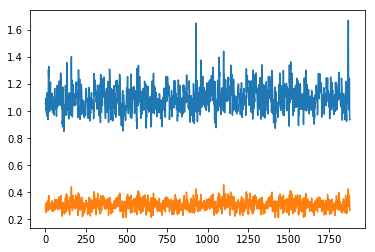

None


In [ ]:
plt.plot((learner.model.layer1.delegate as! ActivationStatistics).activationMeans)
plt.plot((learner.model.layer2.delegate as! ActivationStatistics).activationMeans)
plt.show()